In [509]:
import sys, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tbparse import SummaryReader
from torch_ac.utils import DictList

In [549]:
def sorted_listdir(path):
    files = sorted((f for f in os.listdir(path) if not f.startswith(".")), key=str.lower)
    return files
    
def make_single_plot(ax, data, label, title, color):

    x = data['step']
    median = data['mean_reward']
    # moving average over a window
    #median = median_raw.rolling(window=5).mean()
    std = data['std']

    ax.plot(x, median, color=color, label=label, lw=1)
    ax.fill_between(x, median - std, median + std, color=color, alpha=0.2, lw=0)
    ax.legend(loc="lower left")

def make_plots(results, ax):
    title = results['sequence']
    for approach in results['approach']:
        label = approach
        for stage in results['approach'][approach]:
            if stage == 'train':
                merged_data = results['approach'][approach][stage]['merged']
                num_seeds = len(results['approach'][approach][stage]['data'])
                c = results['approach'][approach][stage]['color']
                make_single_plot(ax, merged_data, label, title, c)

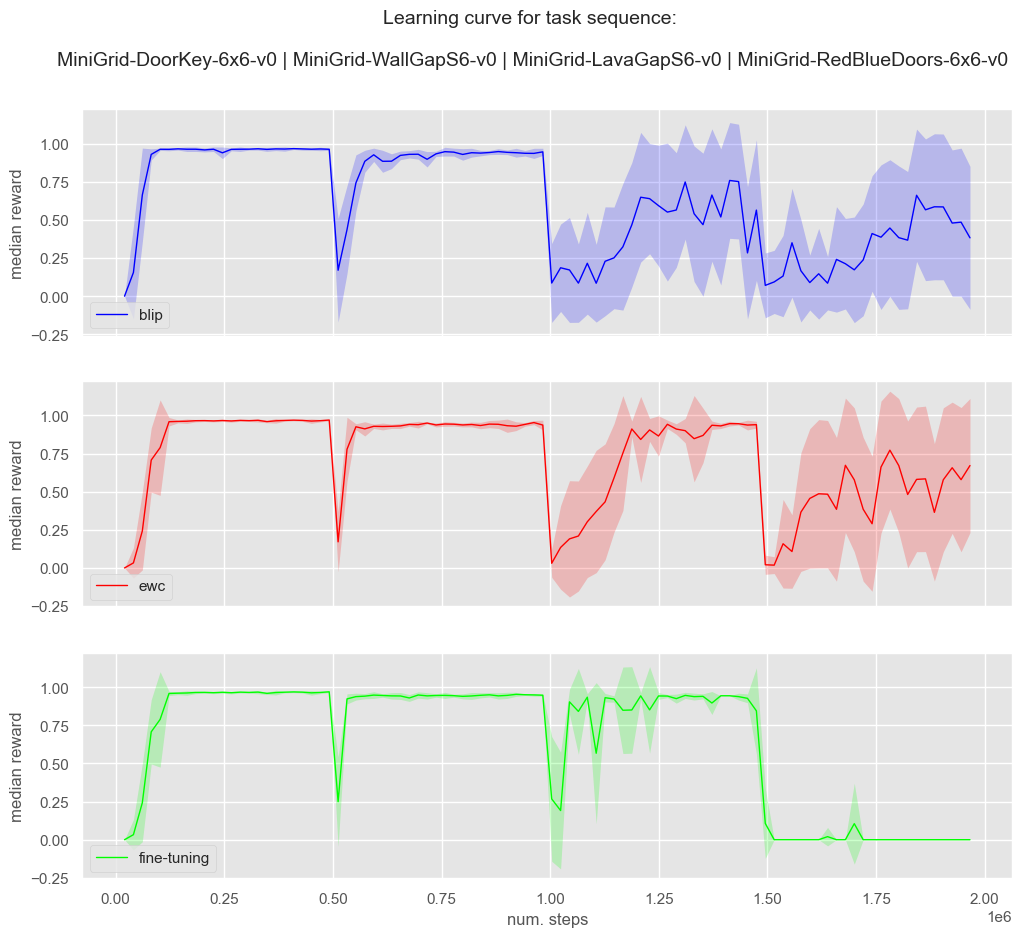

In [550]:
args = {}
args = DictList(args)

date = '2023-01-19'
header = 'minigrid'
steps = '5e5'
experiment = 'doorkey-wallgap-lavagap-redbluedoor'
approaches = ['blip','ewc','fine-tuning']
#approaches = ['blip']
stages = ['train', 'eval']
seeds = [1,2,3]
F_prior = 5e-18
ewc_lambda = 5000.0

results_dict = {}  
df_list = []

task_sequences = [
    (0, 'MiniGrid-DoorKey-6x6-v0'), 
    (1, 'MiniGrid-WallGapS6-v0'), 
    (2, 'MiniGrid-LavaGapS6-v0'),
    (3, 'MiniGrid-RedBlueDoors-6x6-v0')       
    ]
last_task_idx = task_sequences[-1][0]
results_dict['num_tasks'] = len(task_sequences)

# Main plot settings
plt.style.use('ggplot')
color = iter(plt.cm.brg(np.linspace(0, 1, len(approaches))))
fig, axs = plt.subplots(len(approaches), sharey=True, figsize=(12, 10))

sequence = ''
for task in task_sequences:
    if task[0] == len(task_sequences) - 1:
        sequence = sequence + task[1]
    else:
        sequence = sequence + task[1] + ' | '
results_dict['sequence'] = sequence

for n, approach in enumerate(approaches):
    results_dict['approach'] = {approach:{}}
    for i, seed in enumerate(seeds):
        if approach == 'fine-tuning' or approach == 'ft-fix':
            log_name = '{}_{}_{}_{}_{}_{}'.format(date, header, steps, experiment, approach, seed)
        elif approach == 'ewc' in approach:
            log_name = '{}_{}_{}_{}_{}_{}_lamb_{}'.format(date, header, steps, experiment, approach, seed, ewc_lambda)
        elif approach == 'blip':
            log_name = '{}_{}_{}_{}_{}_{}_F_prior_{}'.format(date, header, steps, experiment, approach, seed, F_prior)
        for stage in stages:
            if stage == 'train':   
                if i == 0:
                    results_dict['approach'][approach][stage] = {}
                    results_dict['approach'][approach][stage]['data'] = []

                train_dir = os.path.join("./result_data/", log_name, "train")
                event_file = os.path.join(train_dir, sorted_listdir(train_dir)[0])
                reader = SummaryReader(event_file, pivot=True)
                df = reader.scalars
                df_mean_std = df[['step', 'mean_reward', 'std']]
                results_dict['approach'][approach][stage]['data'].append(df_mean_std)
                # Check if last seed data has been reached and process the data
                if seed == seeds[-1]:
                    df_list = results_dict['approach'][approach][stage]['data']
                    df_all = pd.concat(df_list)
                    df_all_median = pd.concat(df_list).groupby(['step'])['mean_reward'].median().reset_index()
                    df_merged = df_all_median.merge(df_all[['mean_reward','std']].drop_duplicates('mean_reward'), how='left', on='mean_reward')
                    results_dict['approach'][approach][stage]['merged'] = df_merged
                    c = next(color)
                    results_dict['approach'][approach][stage]['color'] = c

                    fig.suptitle('Learning curve for task sequence: '+'\n\n'+results_dict['sequence'], fontsize=14)
                    ax = axs[n]
                    make_plots(results_dict, ax)
                    for ax in axs.flat:
                        ax.set(xlabel='num. steps', ylabel='median reward')
                        ax.label_outer()
                        ax.label_outer()
                    #if "train" in results_dict[approach]:print("This key exists")
                
            elif stage == 'eval':
                if i == 0: results_dict['approach'][approach][stage] = {}
                for task in task_sequences:
                    if i == 0:
                        results_dict['approach'][approach][stage]["task_"+str(task[0])] = {}
                        results_dict['approach'][approach][stage]["task_"+str(task[0])]['name'] = task[1]
                        results_dict['approach'][approach][stage]["task_"+str(task[0])]['data'] = []

                    eval_dir = os.path.join("./result_data/", log_name, "eval", "task_"+str(task[0]))
                    event_file = os.path.join(eval_dir, sorted_listdir(eval_dir)[0])
                    reader = SummaryReader(event_file, pivot=True)
                    df = reader.scalars
                    df_mean_std = df[['step', 'mean_reward', 'std']]
                    results_dict['approach'][approach][stage]["task_"+str(task[0])]['data'].append(df_mean_std)
                    # Check if last seed data has been reached and process the data
                    if seed == seeds[-1]:
                        df_list = results_dict['approach'][approach][stage]["task_"+str(task[0])]['data']
                        df_all = pd.concat(df_list)
                        df_all_median = pd.concat(df_list).groupby(['step'])['mean_reward'].median().reset_index()
                        df_merged = df_all_median.merge(df_all[['mean_reward','std']].drop_duplicates('mean_reward'), how='left', on='mean_reward')

                        results_dict['approach'][approach][stage]["task_"+str(task[0])]['merged'] = df_merged                          


[Text(0, 0.5, 'value'), Text(0.5, 1.0, 'Mean reward')]

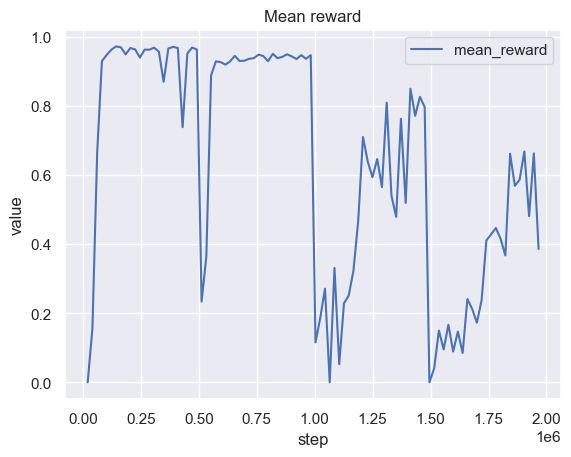

In [126]:
g = sns.lineplot(data=df_mean, x='step', y='value')

g.legend(['mean_reward'])
g.set(ylabel='value', title='Mean reward')

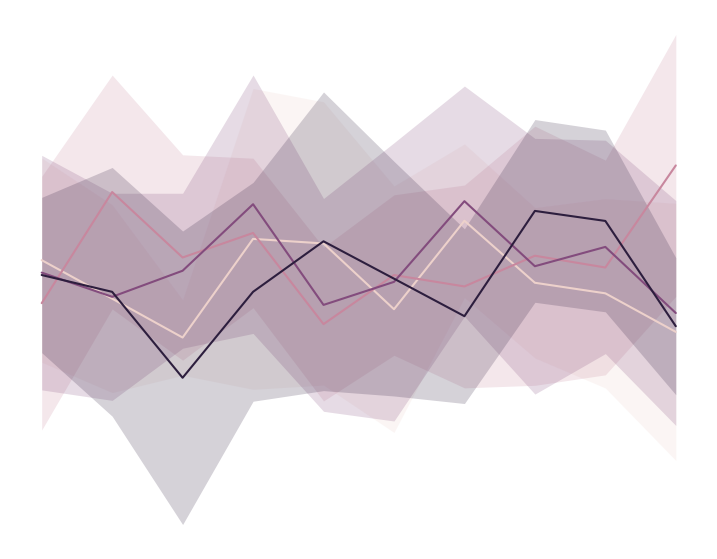

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")   
np.random.seed(2022)  # to produce the same data each time
df = pd.DataFrame({"trial" : np.random.randint(10, size=350),
                   "rvalues" : np.random.randn(350),
                   "subject" : np.random.randint(4, size=350)})

fig, ax = plt.subplots(figsize=(9, 7))
sns.lineplot(x="trial", y="rvalues", hue="subject", err_style="band", err_kws={'lw':0}, 
             errorbar='sd', estimator="median", data=df, ax=ax)
sns.move_legend(ax, loc='upper left', frameon=False)
sns.despine(left=True, bottom=True)

ax.get_legend().remove()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()